In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys
sys.path.append('src/')

import csv
from palettes import DEFAULT_PALETTE
from WADParser import open_wad_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import struct
import re
from copy import deepcopy
from loguru import logger

from mus2mid import mus2mid
from WADViewer import save_music

In [8]:
import ctypes
import time
import threading

In [33]:
w = open_wad_file('WADs/DOOM.WAD')

2025-03-23 19:50:06.545 | INFO     | WADParser:__init__:41 - Found a DOOM IWAD.
2025-03-23 19:50:06.546 | INFO     | WADParser:_get_palette:114 - Palette extracted.
2025-03-23 19:50:06.546 | INFO     | WADParser:_parse_levels:154 - Found 36 level(s) in this WAD.
2025-03-23 19:50:06.546 | INFO     | WADParser:_parse_things:126 - DOOM THINGS loaded.
2025-03-23 19:50:06.546 | INFO     | WADParser:_parse_by_markers:184 - 107 FLATS found in this WAD.
2025-03-23 19:50:06.546 | INFO     | WADParser:_parse_by_markers:184 - 764 SPRITES found in this WAD.
2025-03-23 19:50:06.587 | INFO     | WADParser:_gather_textures:362 - Found 287 textures in 2 texture lumps.
2025-03-23 19:50:06.588 | INFO     | WADParser:_gather_musics:374 - Found 32 music lumps.


In [34]:
music_name = list(w.musics.keys())[0]
output_path = f'output/{music_name}.mid'
save_music(w, music_name, output_path)

2025-03-23 19:50:10.126 | INFO     | WADViewer:save_music:132 - Exported MUS D_E1M1 as a MIDI file.


In [35]:
class MIDIPlayer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.stop_flag = False
        try:
            winmm = ctypes.WinDLL("winmm.dll")
            self.mciSendString = winmm.mciSendStringW
        except AttributeError:
            raise ImportError("winmm.dll not found. This player only works on Windows.")

    def mci_send(self, command):
        buffer = ctypes.create_unicode_buffer(256)
        self.mciSendString(command, buffer, 256, 0)
        return buffer.value
    
    def play_midi(self):
        logger.info(f"Playing MIDI file: {self.file_path}")
        self.stop_flag = False
        self.mci_send(f'open "{self.file_path}" type sequencer alias midi')
        self.mci_send("play midi")

        # Wait until playback finishes or stop is requested
        while self.mci_send("status midi mode") == "playing":
            if self.stop_flag:
                self.stop_midi()
                break
            time.sleep(0.5)

         # Stop normally if not interrupted
        if not self.stop_flag: 
            self.stop_midi()

    def stop_midi(self):
        logger.info("Stopping MIDI playback")
        self.stop_flag = True
        # Stop the currently playing MIDI
        self.mci_send("stop midi")
        time.sleep(0.1)  # Small delay to ensure stop completes
        self.mci_send("close midi")
        time.sleep(0.1)  # Delay to allow reset of alias
        self.mci_send("reset midi")  # Reset MIDI alias to avoid conflicts

    # Start playing MIDI in a separate thread
    def play(self):
        threading.Thread(target=self.play_midi, daemon=True).start()

    # Stop playback
    def stop(self):
        
        self.stop_flag = True  
 

In [36]:
player = MIDIPlayer(output_path)
player.play()


2025-03-23 19:50:11.941 | INFO     | __main__:play_midi:17 - Playing MIDI file: output/D_E1M1.mid


2025-03-23 19:51:49.515 | INFO     | __main__:stop_midi:34 - Stopping MIDI playback


In [32]:
# time.sleep(10)  # Play for 10 seconds
player.stop()

In [ ]:
# Load winmm.dll
winmm = ctypes.WinDLL("winmm.dll")
mciSendString = winmm.mciSendStringW

# Global flag to stop playback
stop_flag = False


# Function to send MCI commands
def mci_send(command):
    buffer = ctypes.create_unicode_buffer(256)
    mciSendString(command, buffer, 256, 0)
    return buffer.value


# Function to play MIDI
def play_midi(file_path):
    global stop_flag
    stop_flag = False
    mci_send(f'open "{file_path}" type sequencer alias midi')
    mci_send("play midi")

    # Wait until playback finishes or stop is requested
    while mci_send("status midi mode") == "playing":
        if stop_flag:
            stop_midi()
            break
        time.sleep(0.5)

    if not stop_flag:  # Stop normally if not interrupted
        stop_midi()


# Function to stop MIDI
def stop_midi():
    global stop_flag
    stop_flag = True
    # Stop the currently playing MIDI
    mci_send("stop midi")
    time.sleep(0.1)  # Small delay to ensure stop completes
    mci_send("close midi")
    time.sleep(0.1)  # Delay to allow reset of alias
    mci_send("reset midi")  # Reset MIDI alias to avoid conflicts


# Start playing MIDI in a separate thread
def start_midi(file_path):
    threading.Thread(target=play_midi, args=(file_path,), daemon=True).start()


# Stop playback
def stop_playback():
    global stop_flag
    stop_flag = True


# Example Usage
# output_path = "example.mid"  # Your MIDI file path here
start_midi(output_path)




In [17]:

stop_playback()

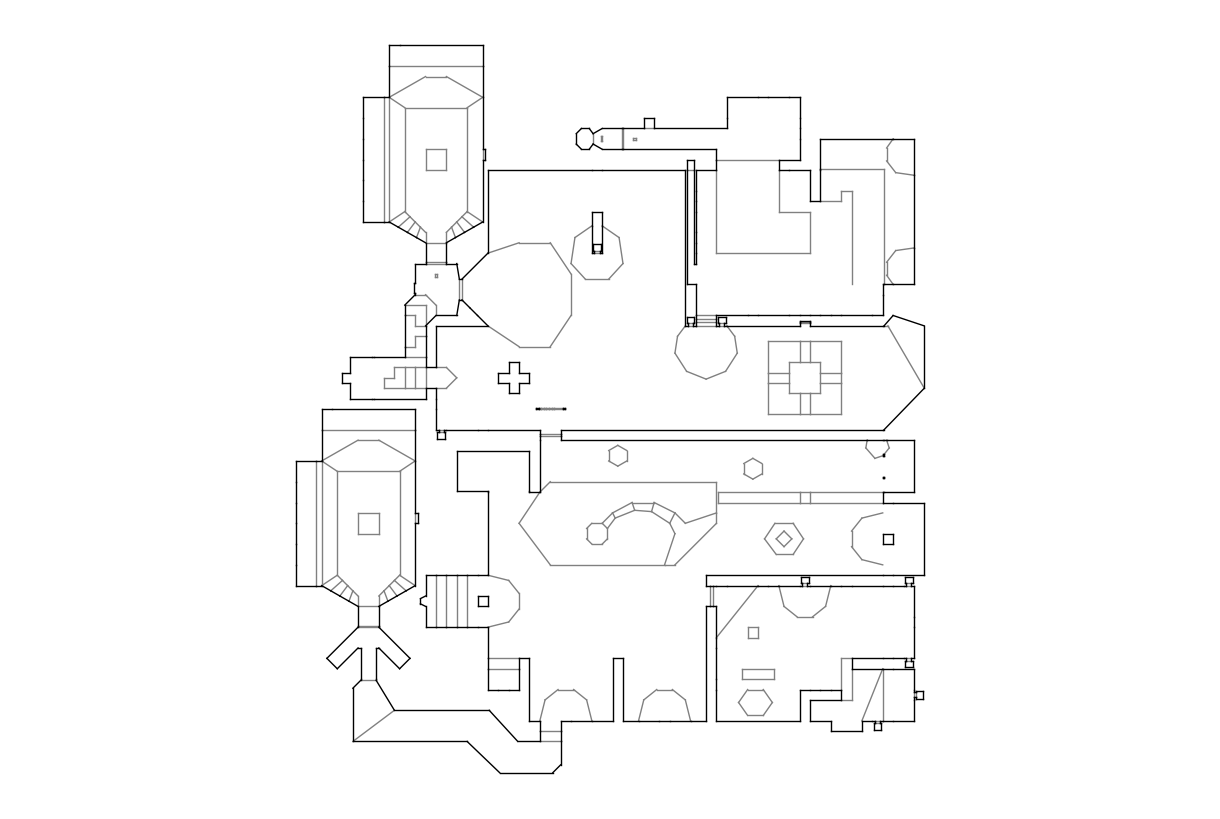

In [5]:
map_infos = w.map('MAP27')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for line in map_infos['steps']:
        ax.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)

for line in map_infos['walls']:
        ax.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

ax.axis('off')
ax.axis('equal')
fig.tight_layout(pad=0)     

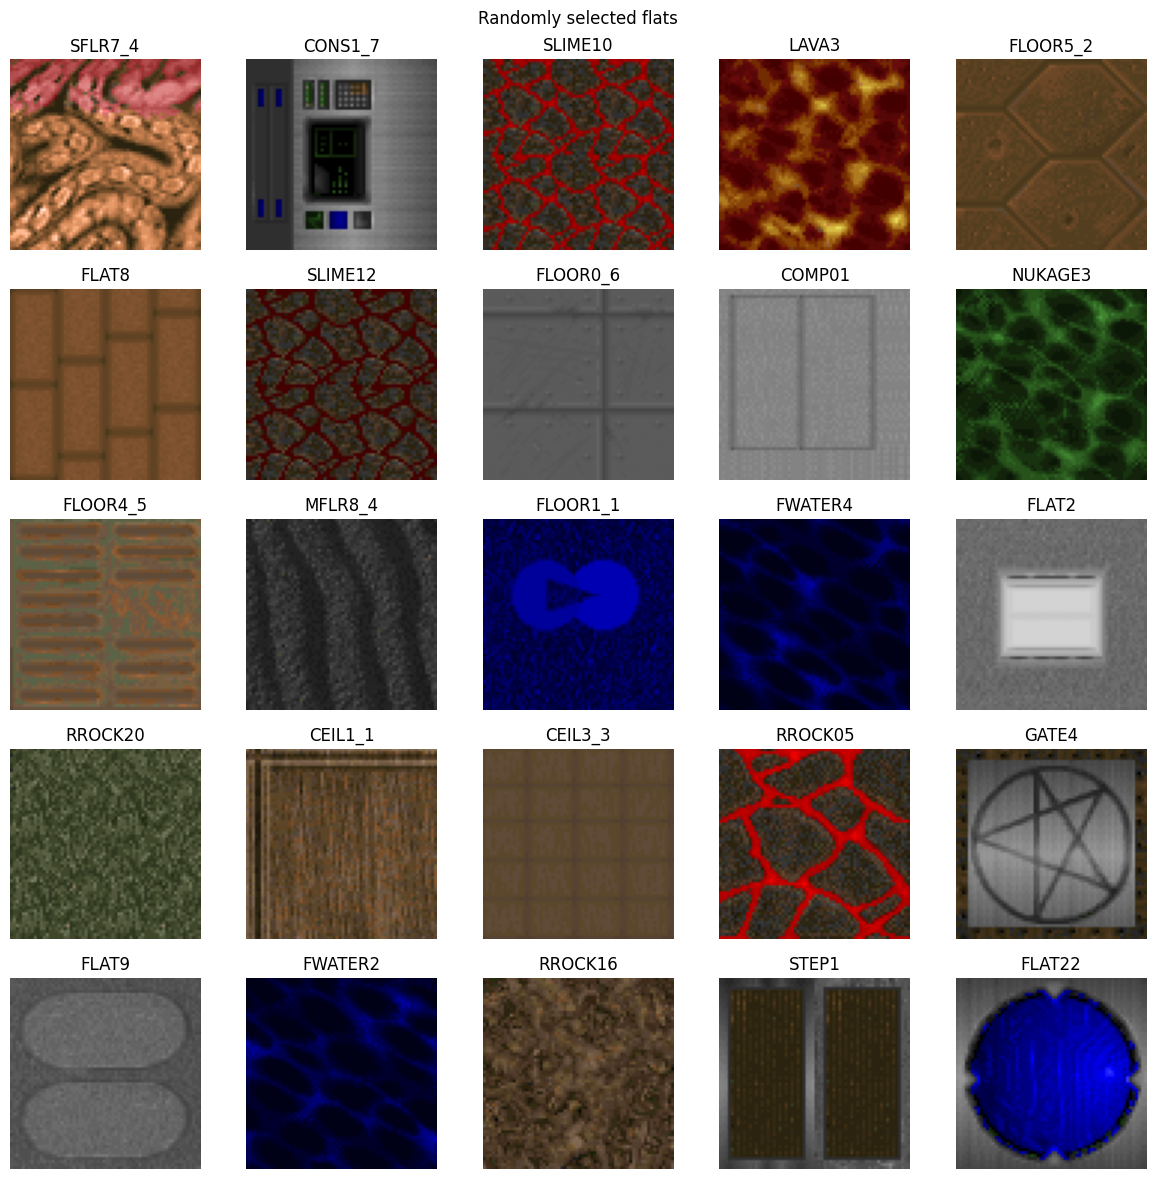

In [40]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

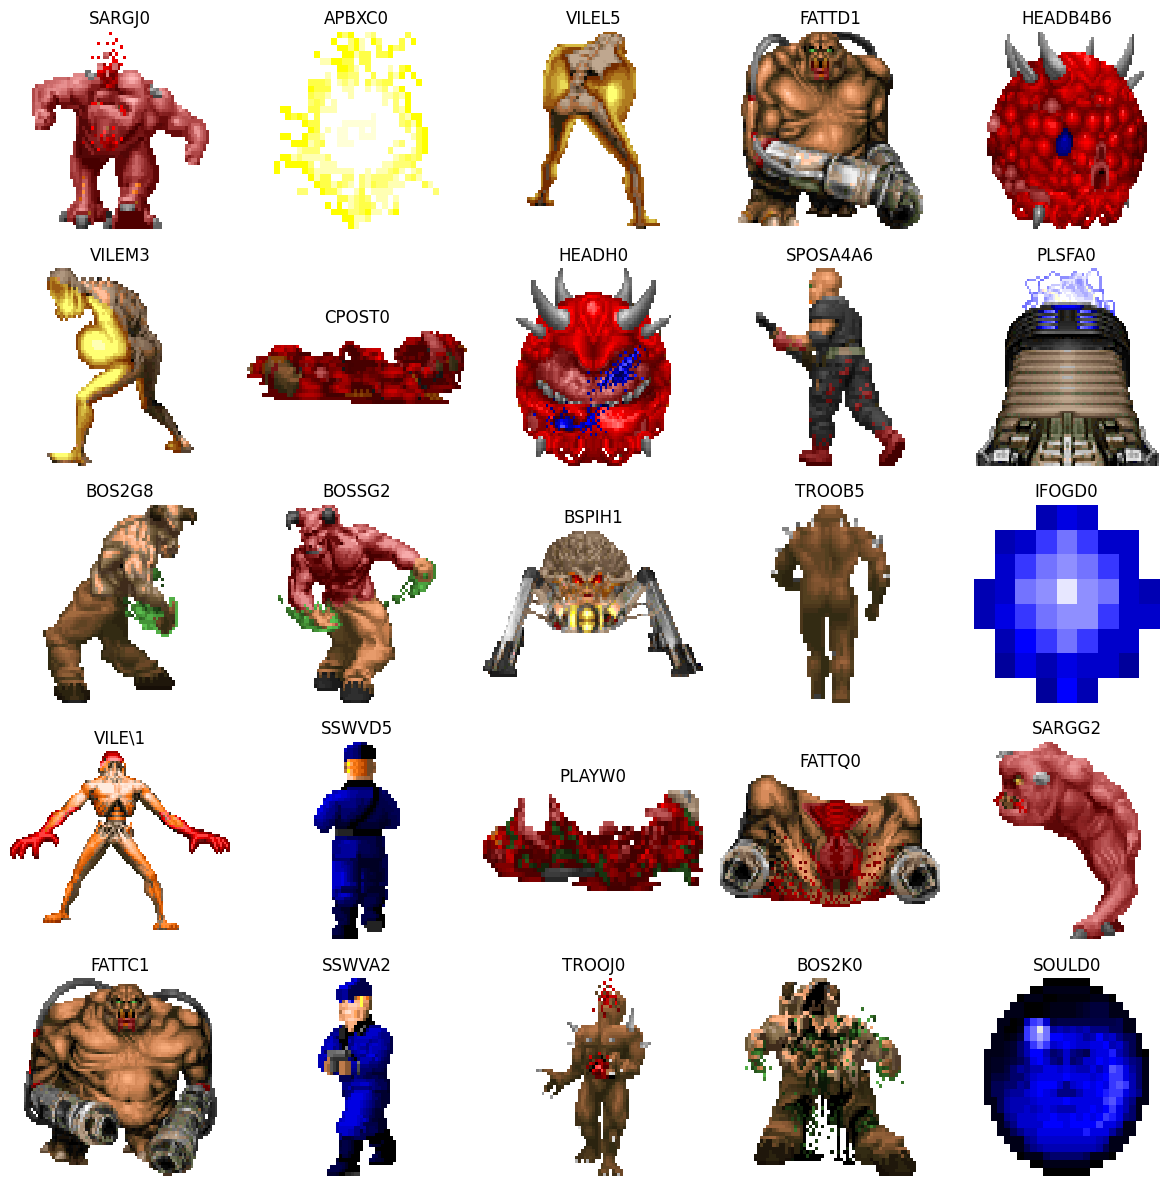

In [41]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

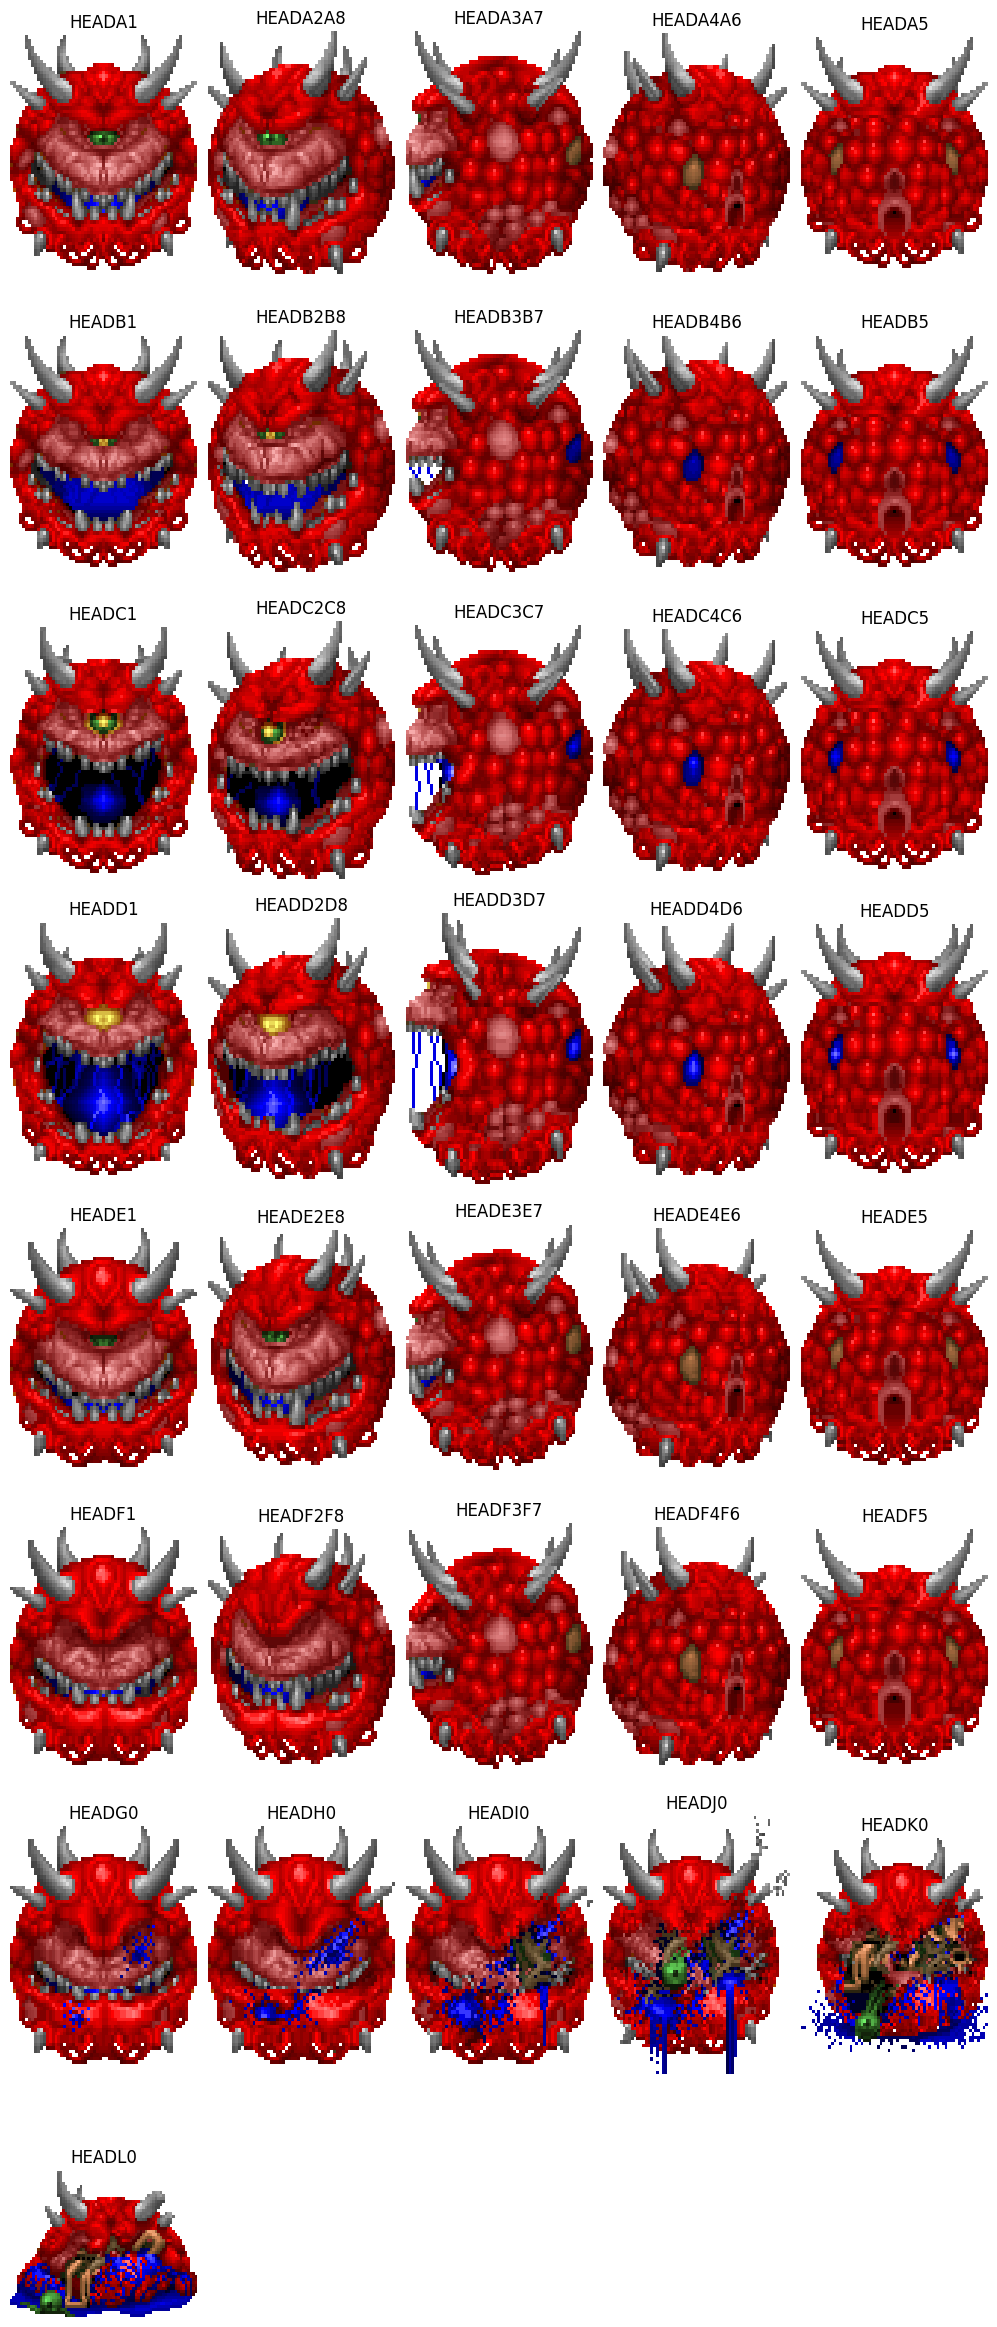

In [42]:
sprite_name = 'HEAD'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [43]:
w.lump_names

['PLAYPAL',
 'COLORMAP',
 'ENDOOM',
 'DEMO1',
 'DEMO2',
 'DEMO3',
 'MAP01',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP02',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP03',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP04',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP05',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP06',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP07',
 'THINGS',
 'LINEDEFS',
 'SIDEDEFS',
 'VERTEXES',
 'SEGS',
 'SSECTORS',
 'NODES',
 'SECTORS',
 'REJECT',
 'BLOCKMAP',
 'MAP08',
 'THINGS',
 'LINEDEFS',
 'SI

In [44]:
music = 'D_DEAD'
idx = w.lump_names.index(music)
name, offset, size = w.lumps[idx]

w.wad.seek(offset)
lump = w.wad.read(size)

lump

b'MUS\x1a%T<\x00\x06\x00\x00\x00\x16\x00\x00\x00\x12\x00\x1e\x00 \x00+\x00.\x00/\x00?\x00P\x00R\x00_\x00k\x00\x87\x00\x88\x00\x8a\x00\x8c\x00\x8d\x00\x8e\x00\x8f\x00\x90\x00\x92\x00\x97\x00\x98\x00@\x00\x12@\x03Z@\x04(\x10\xc2hA\x00\x12A\x03ZA\x04W\x11\xbbhB\x00\x12B\x03ZB\x04@C\x00\x1eC\x03dC\x04@\x13\xafrC\x03dC\x04@D\x00#D\x03dD\x04@D\x00 D\x03dD\x04@E\x00RE\x03dE\x04@O\x00\x00O\x03dO\x04@\x9f\xa4b\x04\x94\xa3b\x1d\x8f$\x06\xc3\x02\x01\x02\xc3\x02\x03\x01\xc3\x02\x06\x01\xc3\x02\x08\x01\xc3\x02\n\x02\xc3\x02\x0b\x01\xc3\x02\x0e\x02\xc3\x02\x0f\x01\xc3\x02\x12\x01\x83/\x01\x136\xc3\x02\x14\x01\xc3\x02\x16\x03\xc3\x02\x19\x01\xc3\x02\x1a\x02\xc3\x02\x1c\x02\xc3\x02\x1d\x02\xc3\x02\x1e\x03\xc3\x02\x1d\x01\xc3\x02\x1b\x02\xc3\x02\x19\x01C\x02\x15\xc3\x02\x11\x02\xc3\x02\r\x01\xc3\x02\t\x02\xc3\x02\x06\x01\xc3\x02\x02\x01\xc3\x02\x00\x1b\x836\x01\x9353\x835\x01\x93/4\x83/\x01\x937"\xc3\x02\x02\x01\xc3\x02\x04\x01\xc3\x02\x06\x01\xc3\x02\x08\x03\xc3\x02\x0b\x02\xc3\x02\r\x01\xc3\x02\x10\x

In [47]:
with open("input.mus", "wb") as f:
    f.write(lump)

In [48]:
get_music('input.mus', 'output.mid')

2025-03-22 18:06:00.125 | INFO     | mus2mid4:get_music:205 - MUS file


In [ ]:
with open('input.mus', 'rb') as musinput, open('output.mid', 'wb') as midioutput:
    mus2mid(musinput, midioutput)

2025-03-22 17:40:18.484 | INFO     | mus2mid4:mus2mid:127 - This is already a MIDI file.


In [23]:
w.wad.seek(offset)
MUS_header, score_len, score_start, channels, sec_channels, instrCnt, dummy = struct.unpack("<4sHHHHHH", w.wad.read(16))
instrList = struct.unpack(f"<{instrCnt}h", w.wad.read(instrCnt * 2))
f"{score_len=}", score_start, channels, sec_channels, instrCnt, instrList

('score_len=17237',
 46,
 3,
 0,
 15,
 (29, 30, 34, 136, 138, 140, 141, 145, 146, 147, 149, 150, 151, 153, 157))